In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from pathlib import Path
import warnings

# Optimization: Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# Visualization: Set a professional style
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# DATA PATH CONFIGURATION
# This assumes the notebook is in 'Backend/notebooks/'
# and data is in 'Backend/data/raw/'
DATA_PATH = Path("../data/raw/BrentOilPrices.csv")

print(f"Target Data Path: {DATA_PATH.resolve()}")

Target Data Path: /Users/admin/week11/brent-oil-bayesian-change-point-analysis/Backend/data/raw/BrentOilPrices.csv


In [2]:
def load_data(path):
    """
    Loads Brent Oil data with correct date parsing.
    """
    try:
        # Expected format: '20-May-87' (%d-%b-%y)
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'], format='mixed')
        df.sort_values('Date', inplace=True)
        df.set_index('Date', inplace=True)

        print(f"Successfully loaded {len(df)} rows.")
        print(f"Date Range: {df.index.min()} to {df.index.max()}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data(DATA_PATH)
print(df.head())
print(df.info())

Successfully loaded 9011 rows.
Date Range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None


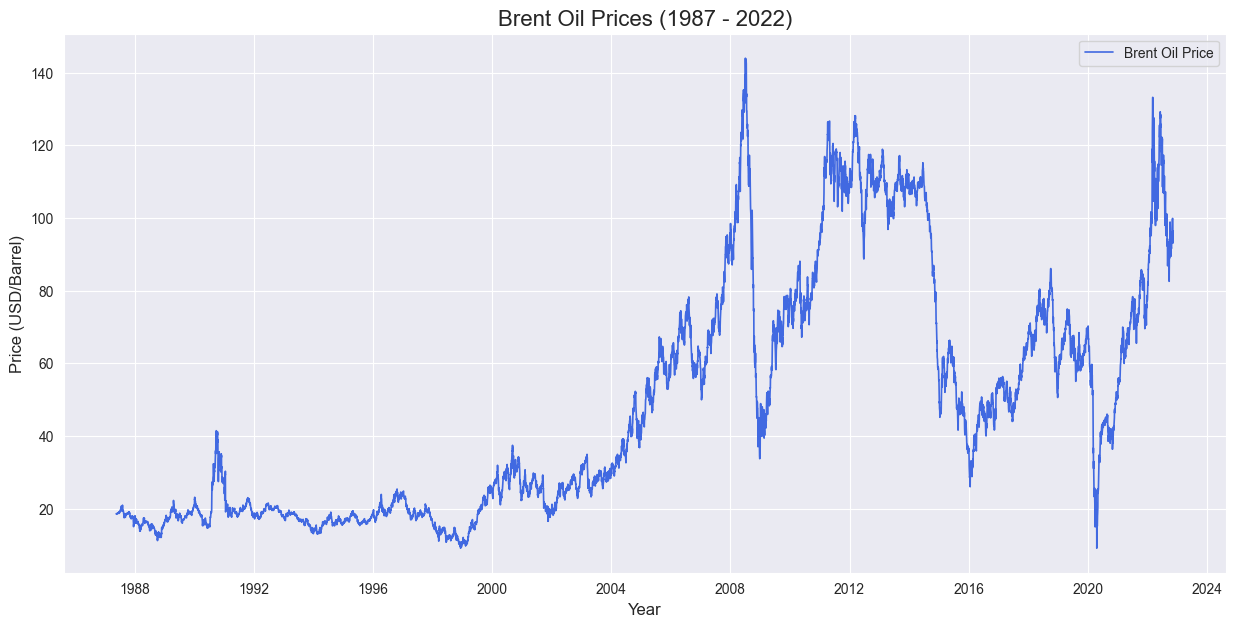

In [3]:
def plot_price_history(df):
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['Price'], color='royalblue', linewidth=1.2, label='Brent Oil Price')
    plt.title('Brent Oil Prices (1987 - 2022)', fontsize=16)
    plt.ylabel('Price (USD/Barrel)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend()
    plt.show()

plot_price_history(df)

In [4]:
def test_stationarity(timeseries):
    """
    Performs Augmented Dickey-Fuller (ADF) test.
    """
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

    # Interpretation
    if dftest[1] <= 0.05:
        print("\nConclusion: Strong evidence against the null hypothesis (p <= 0.05). The series is Stationary.")
    else:
        print("\nConclusion: Weak evidence against the null hypothesis (p > 0.05). The series is Non-Stationary.")

test_stationarity(df['Price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.993856
p-value                           0.289274
#Lags Used                       29.000000
Number of Observations Used    8981.000000
Critical Value (1%)              -3.431078
Critical Value (5%)              -2.861862
Critical Value (10%)             -2.566941
dtype: float64

Conclusion: Weak evidence against the null hypothesis (p > 0.05). The series is Non-Stationary.


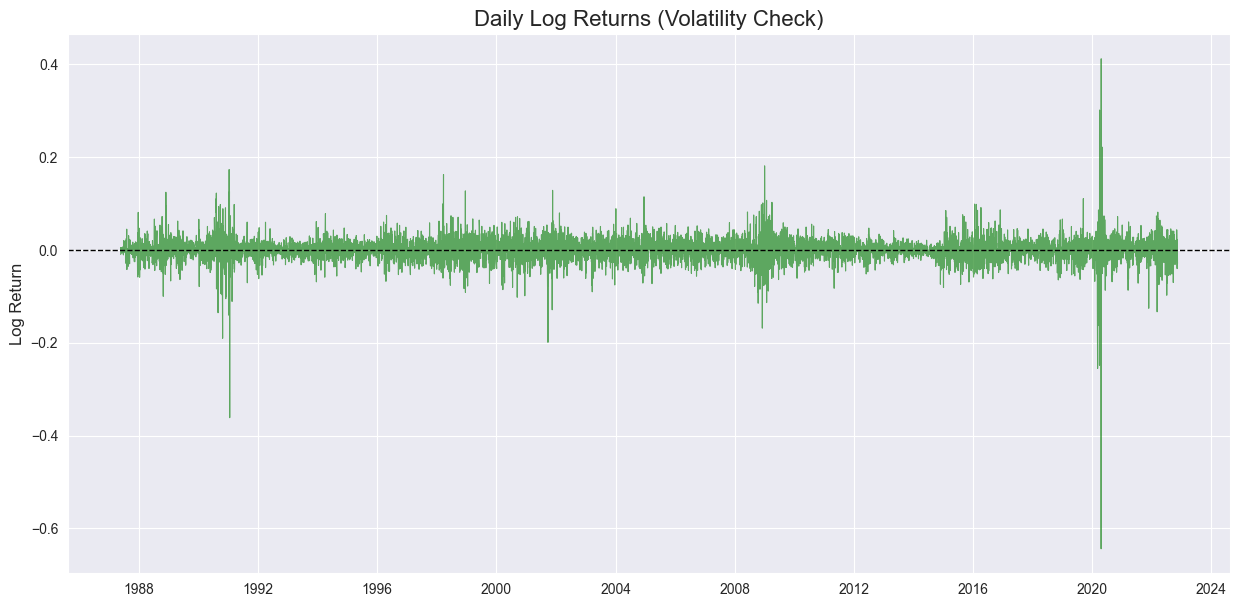

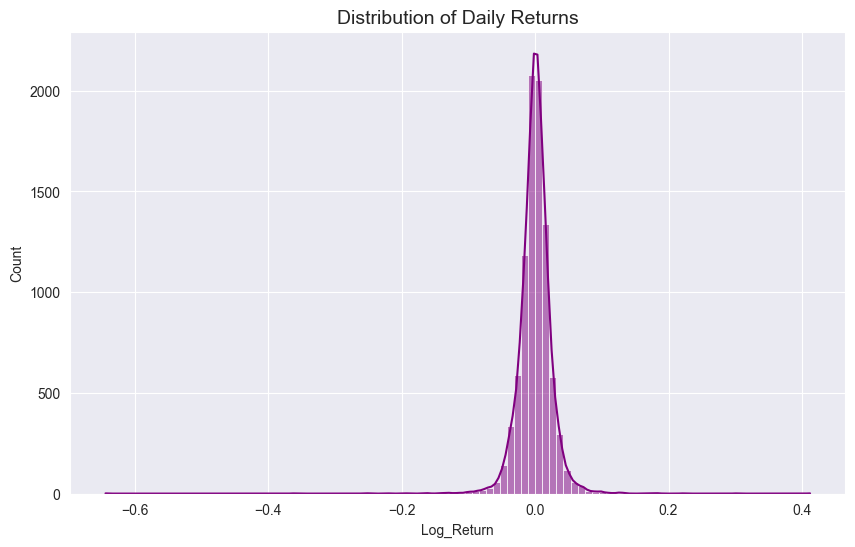

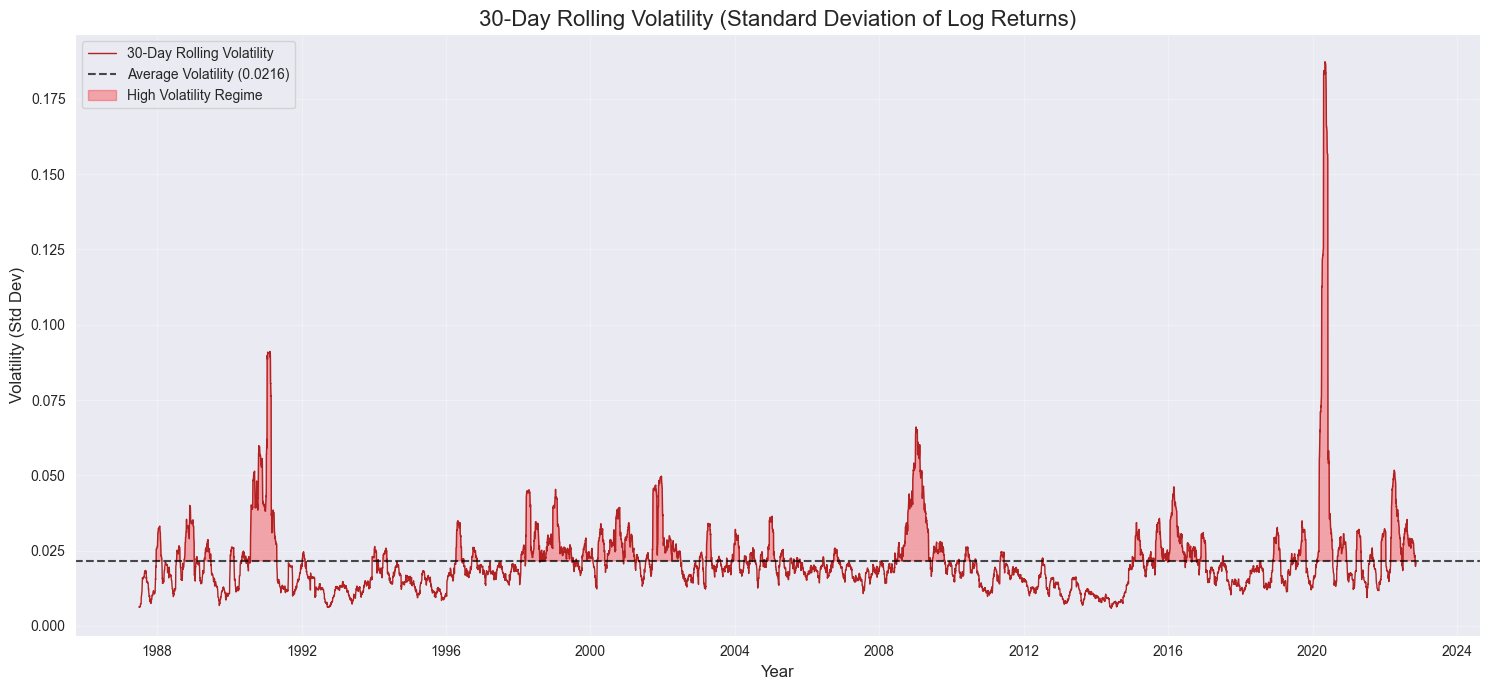

In [5]:
# Calculate Log Returns
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

# Drop the first NaN created by the shift
df_clean = df.dropna()

plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean['Log_Return'], color='forestgreen', linewidth=0.8, alpha=0.7)
plt.title('Daily Log Returns (Volatility Check)', fontsize=16)
plt.ylabel('Log Return', fontsize=12)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.show()

# Quick histogram to check distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Log_Return'], bins=100, kde=True, color='purple')
plt.title('Distribution of Daily Returns', fontsize=14)
plt.show()


def plot_volatility(df, window=30):
    """
    Calculates and plots the rolling volatility (standard deviation of returns).
    """
    # 1. Calculate Rolling Standard Deviation
    # We use Log Returns because they are time-additive and handle extreme moves better
    volatility = df['Log_Return'].rolling(window=window).std()

    # Optional: Annualize the volatility for a "Wall Street" standard view
    # (Assuming 252 trading days in a year)
    # annualized_vol = volatility * np.sqrt(252)

    plt.figure(figsize=(15, 7))

    # Plot the volatility
    plt.plot(df.index, volatility, color='firebrick', linewidth=1, label=f'{window}-Day Rolling Volatility')

    # Add a horizontal line for the mean volatility to show "calm" vs "crisis"
    mean_vol = volatility.mean()
    plt.axhline(mean_vol, color='black', linestyle='--', alpha=0.7, label=f'Average Volatility ({mean_vol:.4f})')

    # Aesthetic touches
    plt.fill_between(df.index, volatility, mean_vol, where=(volatility > mean_vol),
                     color='red', alpha=0.3, interpolate=True, label='High Volatility Regime')

    plt.title(f'{window}-Day Rolling Volatility (Standard Deviation of Log Returns)', fontsize=16)
    plt.ylabel('Volatility (Std Dev)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Execute
plot_volatility(df)

In [6]:
# EVENT DATA PATH
# Assuming it's in the processed folder based on your directory structure
EVENTS_PATH = Path("../data/processed/key_events.csv")

def load_events(path):
    try:
        events = pd.read_csv(path)
        events['Date'] = pd.to_datetime(events['Date'])
        events.sort_values('Date', inplace=True)
        print(f"Successfully loaded {len(events)} key events.")
        return events
    except Exception as e:
        print(f"Error loading events: {e}")
        return None

events_df = load_events(EVENTS_PATH)
events_df.head()

Successfully loaded 22 key events.


,Event_ID,Event_Name,Event_Type,Date,Description,Source
0,1,First Gulf War,Geopolitical Conflict,1990-08-02,Iraq invades Kuwait causing a major oil supply...,EIA; BP Statistical Review
1,2,Asian Financial Crisis,Economic Shock,1997-07-02,Collapse of Asian economies reduced global oil...,IMF; World Bank
2,3,OPEC Coordinated Production Cuts,OPEC Policy,1999-03-01,OPEC agreed on coordinated cuts to stabilize o...,OPEC Annual Report
3,4,September 11 Attacks,Geopolitical Shock,2001-09-11,Terrorist attacks increased geopolitical risk ...,EIA; Bloomberg
4,5,Iraq War,Geopolitical Conflict,2003-03-20,US-led invasion of Iraq disrupted Middle East ...,EIA


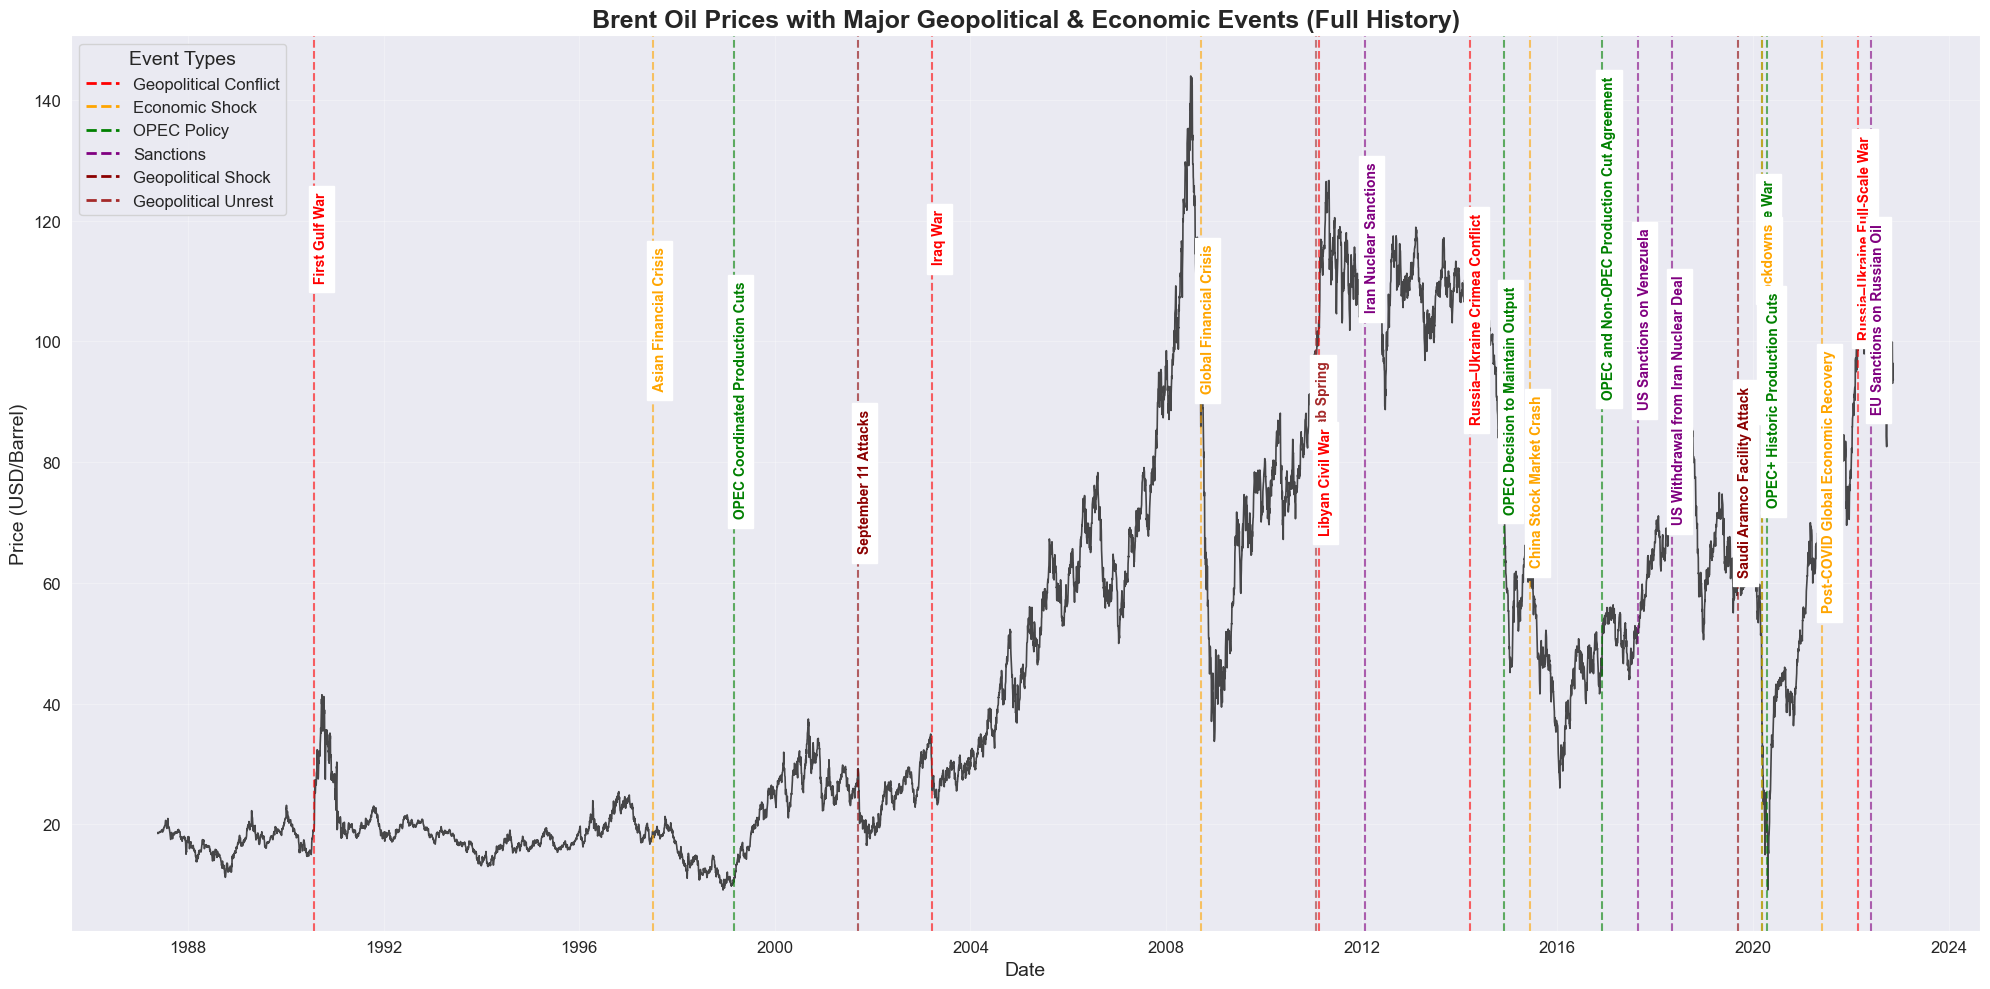

Generating Full History Plot...


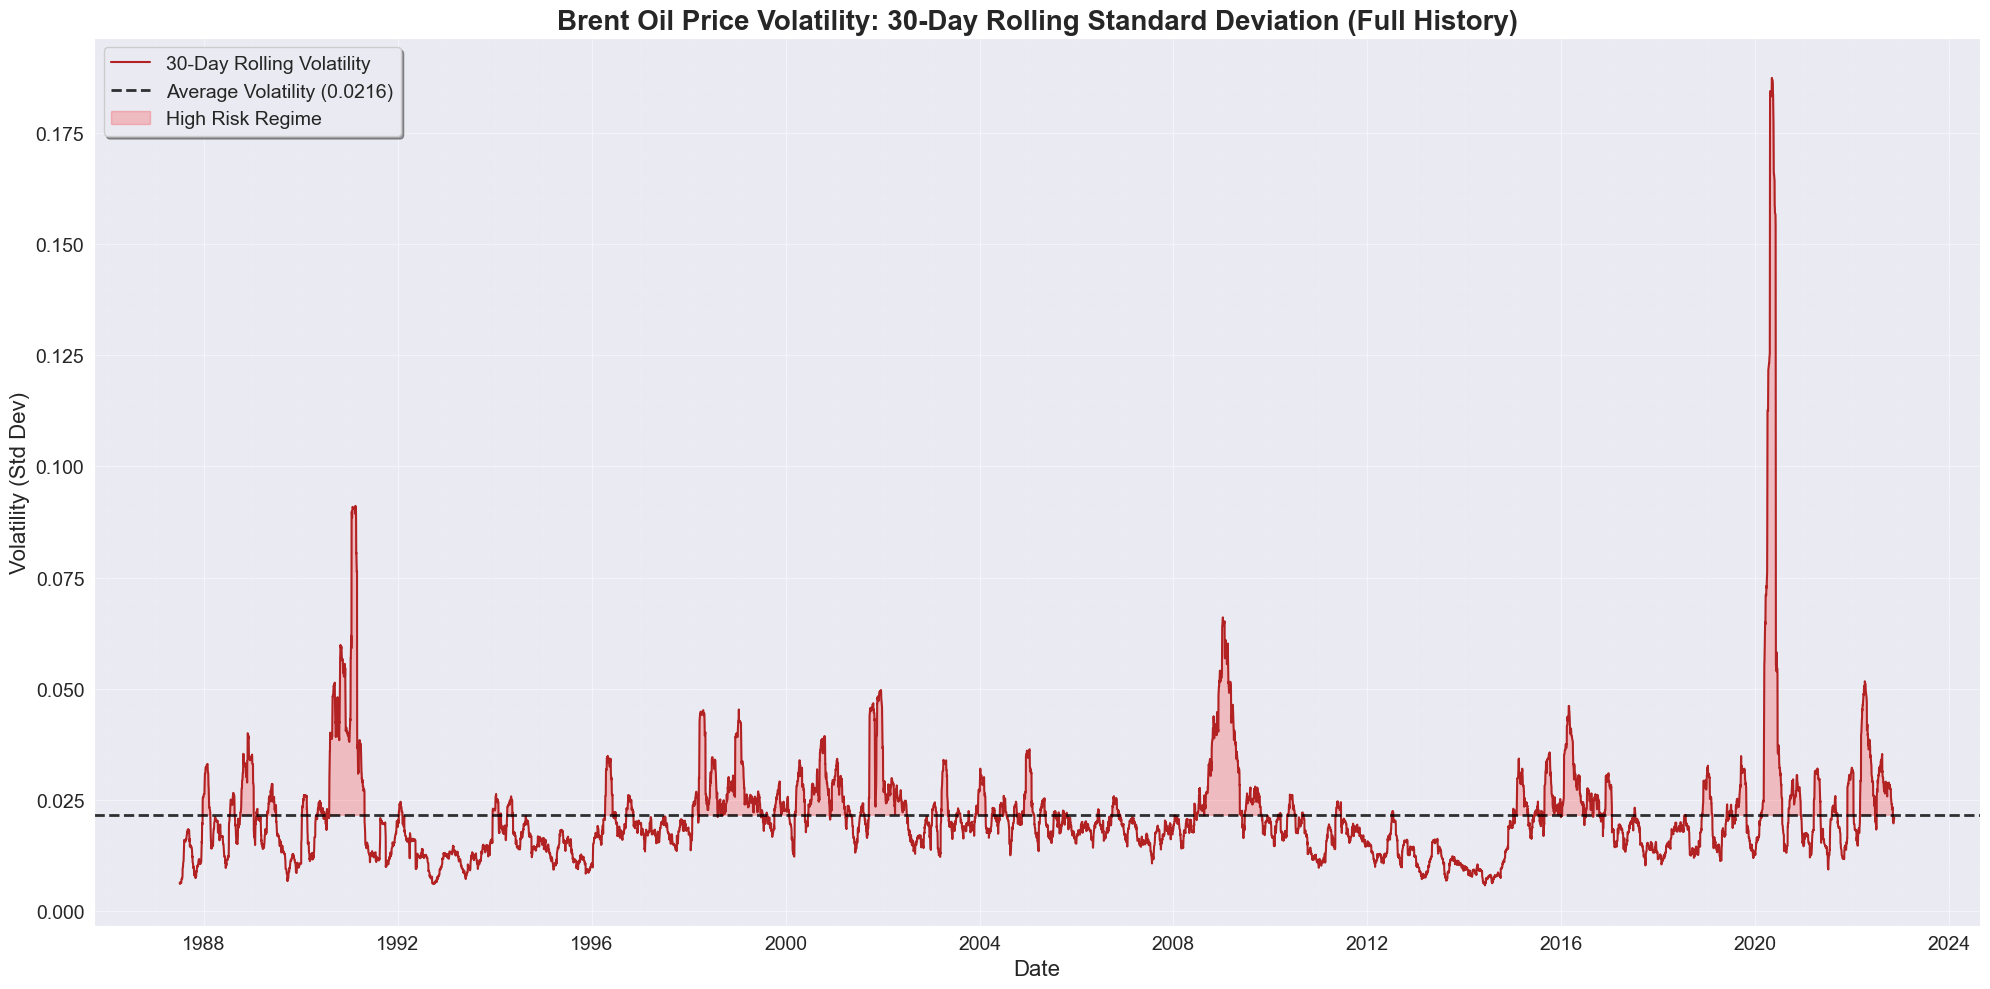


Generating Zoomed Plot for 2008 Financial Crisis...


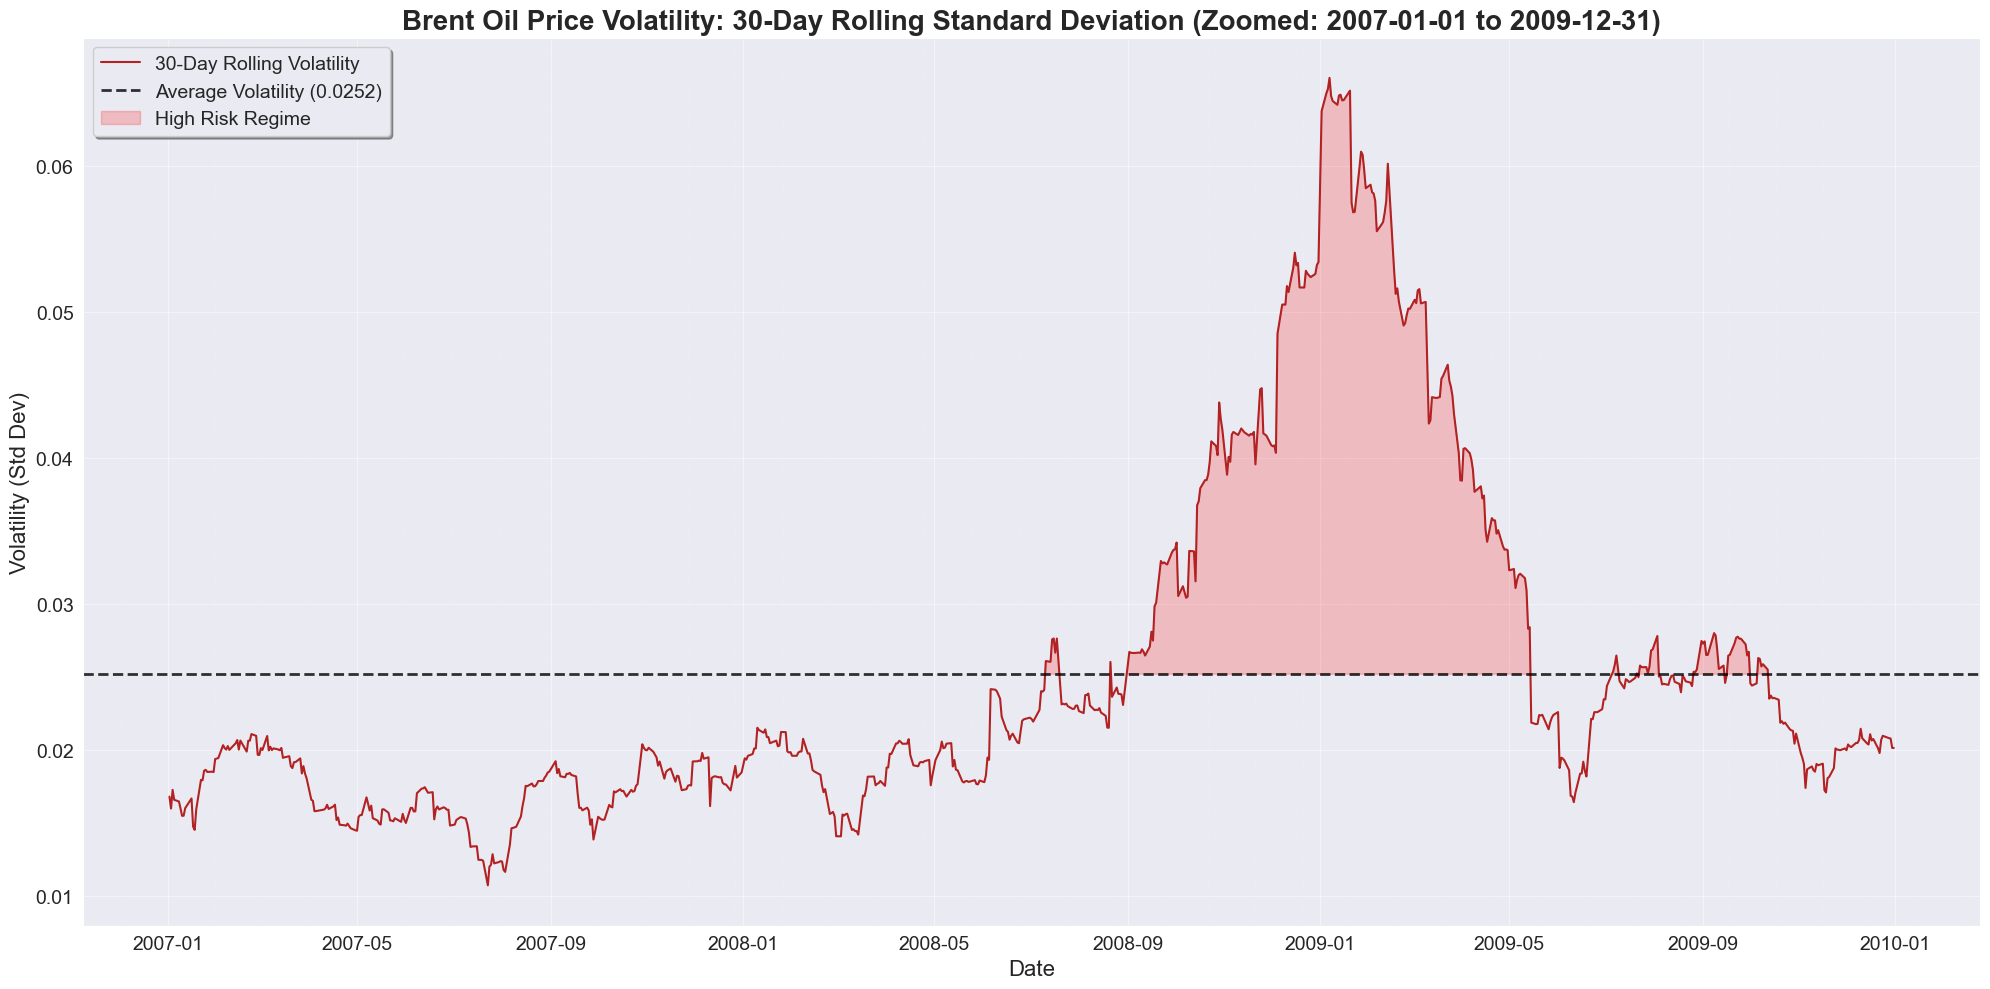


Generating Zoomed Plot for COVID-19 Shock...


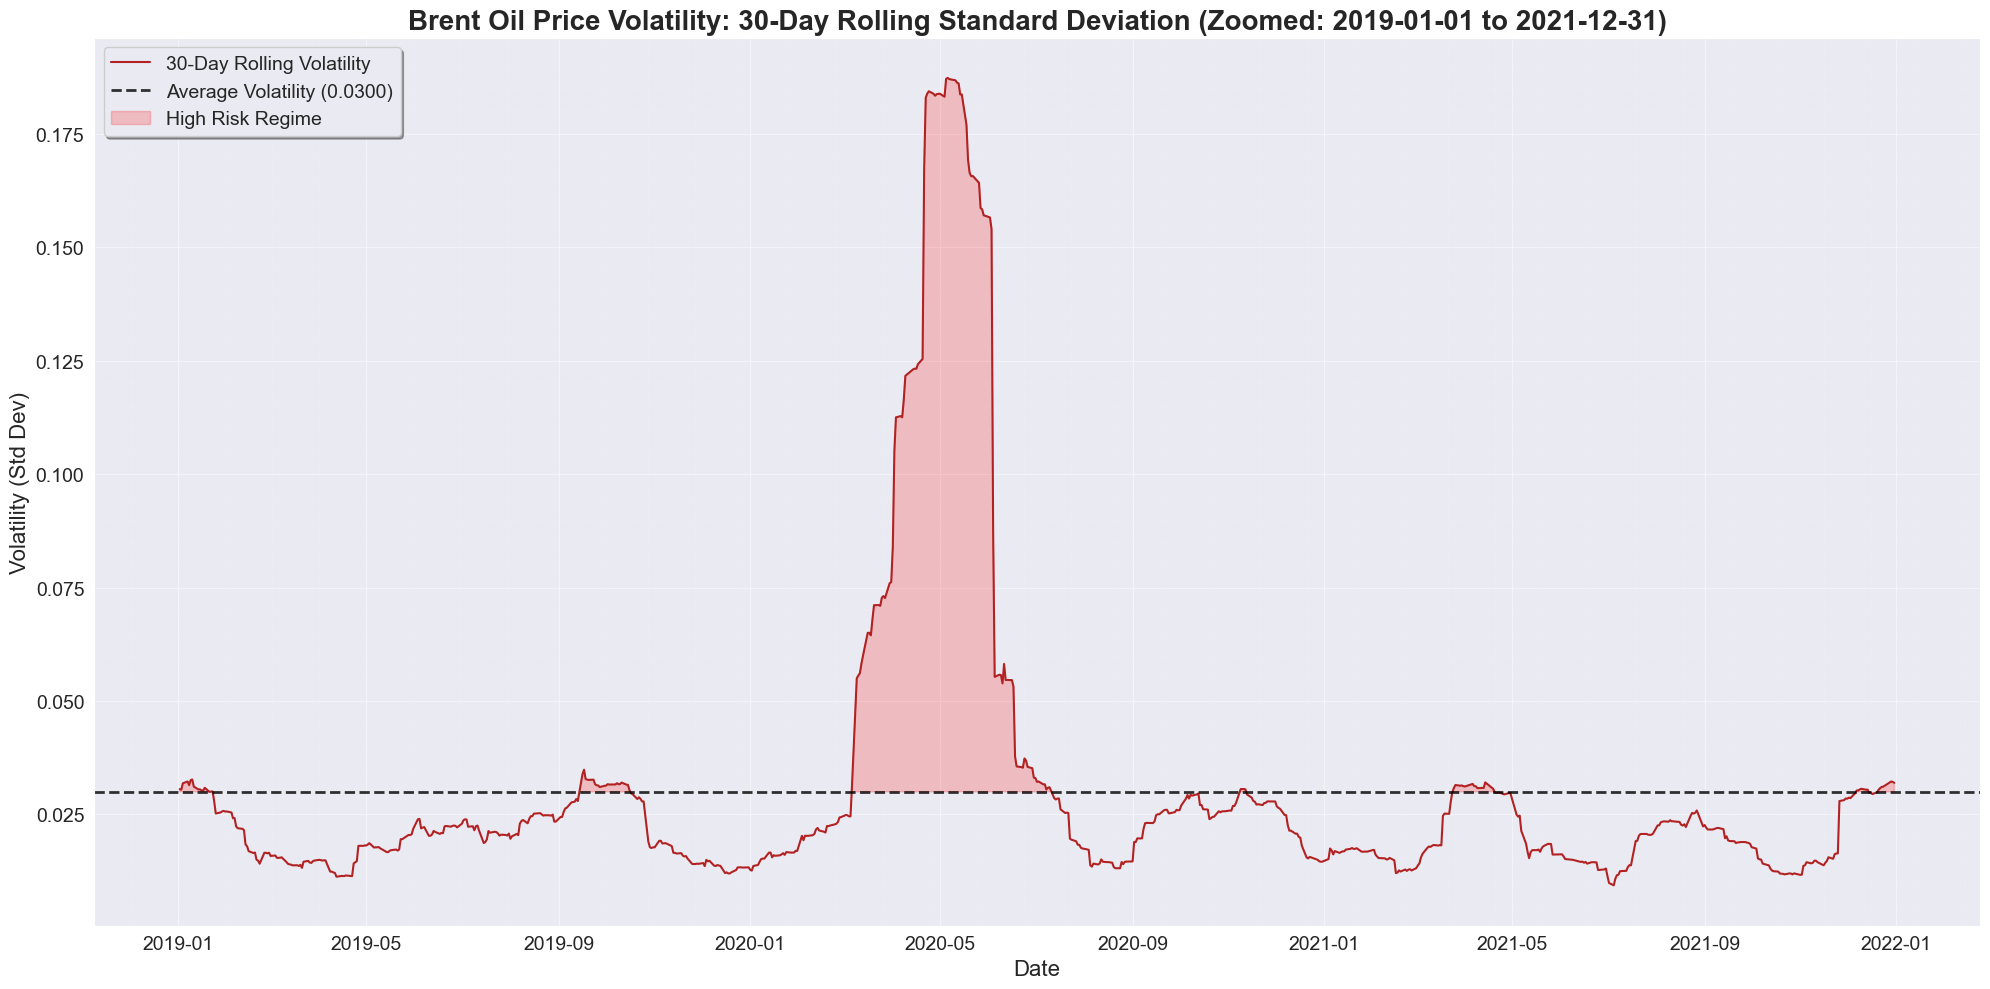

In [7]:
def plot_prices_with_events_adjusted(price_df, event_df, date_range=None):
    """
    Plots Brent Oil Prices with overlaid events, supporting zoom and dynamic labeling.
    """
    # 1. Filter Data for Zoom (if requested)
    if date_range:
        start_date, end_date = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
        plot_prices = price_df.loc[start_date:end_date]
        # Filter events to those inside the range
        plot_events = event_df[(event_df['Date'] >= start_date) & (event_df['Date'] <= end_date)]
        title_suffix = f" (Zoomed: {date_range[0]} to {date_range[1]})"
    else:
        plot_prices = price_df
        plot_events = event_df
        title_suffix = " (Full History)"

    # 2. Setup Plot
    plt.figure(figsize=(20, 10))

    # Plot Brent Oil Price
    plt.plot(plot_prices.index, plot_prices['Price'], color='black', linewidth=1.2, alpha=0.7, label='Brent Oil Price')

    # 3. Define Colors for Event Types
    colors = {
        'Geopolitical Conflict': 'red',
        'Economic Shock': 'orange',
        'OPEC Policy': 'green',
        'Sanctions': 'purple',
        'Geopolitical Shock': 'darkred',
        'Geopolitical Unrest': 'brown'
    }

    # 4. Overlay Events
    # Get the local max price for positioning text dynamically
    local_max_price = plot_prices['Price'].max()
    local_min_price = plot_prices['Price'].min()
    price_range = local_max_price - local_min_price

    for i, (_, row) in enumerate(plot_events.iterrows()):
        event_date = row['Date']
        event_type = row['Event_Type']
        event_name = row['Event_Name']

        # Color logic
        color = colors.get(event_type, 'blue')

        # Vertical Line
        plt.axvline(x=event_date, color=color, linestyle='--', alpha=0.6, linewidth=1.5)

        # Dynamic Text Positioning (Staggered)
        # We calculate height relative to the *visible* plot range to keep it neat
        # Stagger between 80%, 70%, 60%, 50% of the visible range height
        stagger_levels = [0.8, 0.70, 0.60, 0.50]
        level = stagger_levels[i % 4]
        text_y_pos = local_min_price + (price_range * level)

        plt.text(event_date, text_y_pos, f" {event_name}",
                 rotation=90, verticalalignment='center',
                 fontsize=10, color=color, fontweight='bold',
                 backgroundcolor='white') # Added background for readability

    # 5. Custom Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=2, linestyle='--') for c in colors.values()]
    plt.legend(custom_lines, colors.keys(), loc='upper left', title="Event Types", fontsize=12, title_fontsize=14)

    # 6. Styling
    plt.title(f'Brent Oil Prices with Major Geopolitical & Economic Events{title_suffix}', fontsize=18, fontweight='bold')
    plt.ylabel('Price (USD/Barrel)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- EXAMPLES ---

# 1. Full History (Your original view, but cleaner)
plot_prices_with_events_adjusted(df, events_df)

# 2. Zoomed View (e.g., 2010-2015 for Arab Spring & Sanctions)
# plot_prices_with_events_adjusted(df, events_df, date_range=('2010-01-01', '2015-12-31'))

def plot_volatility_zoomed(df, window=30, date_range=None):
    """
    Calculates 30-Day Rolling Volatility with options to zoom in on specific dates.

    Parameters:
    - df: DataFrame containing 'Log_Return'
    - window: Rolling window size (default 30 days)
    - date_range: Tuple of strings ('start_date', 'end_date') to zoom in. Example: ('2007-01-01', '2009-12-31')
    """
    # 1. Calculate Volatility (Standard Deviation of Log Returns)
    volatility = df['Log_Return'].rolling(window=window).std()

    # 2. Filter for Zoom (if requested)
    if date_range:
        start_date, end_date = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
        # Mask the data to the specific range
        mask = (volatility.index >= start_date) & (volatility.index <= end_date)
        plot_data = volatility.loc[mask]
        title_suffix = f" (Zoomed: {date_range[0]} to {date_range[1]})"
    else:
        plot_data = volatility
        title_suffix = " (Full History)"

    # 3. Create a Large, Clear Plot
    plt.figure(figsize=(20, 10))  # significantly larger for readability

    # Plot the volatility curve
    plt.plot(plot_data.index, plot_data, color='firebrick', linewidth=1.5, label=f'{window}-Day Rolling Volatility')

    # Add Mean Volatility Line
    mean_vol = plot_data.mean()
    plt.axhline(mean_vol, color='black', linestyle='--', linewidth=2, alpha=0.8, label=f'Average Volatility ({mean_vol:.4f})')

    # Highlight High Volatility Regimes
    plt.fill_between(plot_data.index, plot_data, mean_vol, where=(plot_data > mean_vol),
                     color='red', alpha=0.2, interpolate=True, label='High Risk Regime')

    # 4. Styling for Stakeholder Readability
    plt.title(f'Brent Oil Price Volatility: {window}-Day Rolling Standard Deviation{title_suffix}', fontsize=20, fontweight='bold')
    plt.ylabel('Volatility (Std Dev)', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper left', fontsize=14, frameon=True, shadow=True)
    plt.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.5)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.3)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()

# --- EXAMPLES OF HOW TO USE ---

# 1. Plot the Full History (Big & Clear)
print("Generating Full History Plot...")
plot_volatility_zoomed(df)

# 2. Zoom in on the 2008 Financial Crisis (Stakeholder Deep Dive)
print("\nGenerating Zoomed Plot for 2008 Financial Crisis...")
plot_volatility_zoomed(df, date_range=('2007-01-01', '2009-12-31'))

# 3. Zoom in on COVID-19 (2020)
print("\nGenerating Zoomed Plot for COVID-19 Shock...")
plot_volatility_zoomed(df, date_range=('2019-01-01', '2021-12-31'))